# UTILITIES

In [1]:
import matplotlib.pyplot as plt
def view_results_multiple_dim(r_list, label_list, has_track_list, num_seq, prior_seqs, init_priors,
                             save_fig, folder, dump_data, rescale_latent=None, view_tracking=False,
                             num_dim=None, show_no_tracking=False):
    if dump_data:
        with open("{}data_results.pkl".format(folder), "wb") as output:
            pickle.dump(r_list, output)

    for seq in range(num_seq):
        # View rewards
        for r, label, has_track in zip(r_list, label_list, has_track_list):
            r = np.array(r)
            if not has_track:
                r = np.array([r[i][seq] for i in range(r.shape[0])])
                plt.plot(np.mean(r, 0), label=label)
                print("Seq {} Algo {} = {} +- {}".format(seq, label, np.mean(r), np.std(r)))
            else:
                t = np.array([r[p, 0, seq] for p in range(r.shape[0])])
                plt.plot(np.mean(t, 0), label=label + " True sigma")
                print("Seq {} Algo {} = {} +- {}".format(seq, label, np.mean(t), np.std(t)))
                
                #t = np.array([r[p, 1, seq] for p in range(r.shape[0])])
                #plt.plot(np.mean(t, 0), label=label + " False sigma")

                t = np.array([r[p, 2, seq] for p in range(r.shape[0])])
                plt.plot(np.mean(t, 0), label=label + " True prior")
                print("Seq {} Algo True prior {} = {} +- {}".format(seq, label, np.mean(t), np.std(t)))

                if show_no_tracking:
                    t = np.array([r[p, 3, seq] for p in range(r.shape[0])])
                    plt.plot(np.mean(t, 0), label=label + " No tracking")
                    print("Seq {} Algo No tracking {} = {} +- {}".format(seq, label, np.mean(t), np.std(t)))


        plt.title("Seq idx {}".format(seq))
        plt.legend(title='legend', bbox_to_anchor=(1.05, 1), loc='upper left')
        if save_fig:
            plt.savefig("{}seq_{}_reward".format(folder, seq))
        plt.show()
        print("Here")
        if view_tracking:
            # View tracking
            for d in range(num_dim):
                for r, label, has_track in zip(r_list, label_list, has_track_list):
                    r = np.array(r)
                    if has_track:
                        seq_len = len(prior_seqs[seq])
                        x = np.arange(seq_len)
                        t = np.array([r[p, 4, seq][:, :, d].mean(1).tolist() for p in range(r.shape[0])])
                        if rescale_latent is not None:
                            t = ((rescale_latent[1] - rescale_latent[0]) / (1 - (-1))) * (t - 1) + rescale_latent[1]
                        plt.plot(x, np.mean(t, 0), label=label + " Posterior true")

                        #t = np.array([r[p, 6, seq][:, :, d].mean(1).tolist() for p in range(r.shape[0])])
                        #if rescale_latent is not None:
                        #    t = ((rescale_latent[1] - rescale_latent[0]) / (1 - (-1))) * (t - 1) + rescale_latent[1]
                        #plt.plot(x, np.mean(t, 0), label=label + " Posterior false")
                        
                        t = np.array([r[p, 5, seq] for p in range(r.shape[0])])[:, :, d]
                        t = np.mean(t, 0)
                        t2 = np.zeros(t.shape[0])
                        t2[1:] = t[:-1]
                        t2[0] = init_priors[seq][0][0][d].item()
                        if rescale_latent is not None:
                            t2 = ((rescale_latent[1] - rescale_latent[0]) / (1 - (-1))) * (t2 - 1) + rescale_latent[1]
                        plt.plot(x, t2, label=label + " Prediction true")

                        #t = np.array([r[p, 7, seq] for p in range(r.shape[0])])
                        #t = np.mean(t, 0)
                        #t2 = np.zeros(t.shape[0])
                        #t2[1:] = t[:-1]
                        #t2[0] = init_priors[seq][0][0].item()
                        #if rescale_latent is not None:
                        #    t2 = ((rescale_latent[1] - rescale_latent[0]) / (1 - (-1))) * (t2 - 1) + rescale_latent[1]
                        #plt.plot(x, t2, label=label + " Posterior false")

                num_t = len(prior_seqs[seq])
                true_task = np.array([prior_seqs[seq][i][0][d].item() for i in range(num_t)])
                if rescale_latent is not None:
                    true_task = ((rescale_latent[1] - rescale_latent[0]) / (1 - (-1))) * (true_task - 1) + \
                                rescale_latent[1]
                plt.plot(true_task, label="True task")

                plt.title("Seq idx {}".format(seq))
                plt.legend(title='legend', bbox_to_anchor=(1.05, 1), loc='upper left')
                if save_fig:
                    plt.savefig("{}seq_{}_tracking".format(folder, seq))
                plt.show()


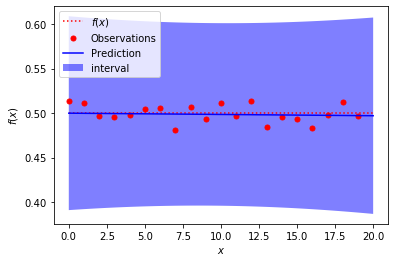

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, DotProduct, ConstantKernel as C

def f(x):
    return np.ones(x.shape[0]) * 0.5


# Train on [0,1,...,H-1] and test on [0,1,...,H]
horizon = 20
# Noise standard deviation
sigma = 0.01
# Minimum prediction standard deviation
min_std = 0.01

x_train = np.atleast_2d(np.arange(horizon)).T
y_train = f(x_train).ravel()

y_train = y_train + np.random.randn(y_train.shape[0]) * sigma

x_test = np.atleast_2d(np.linspace(0, horizon, 1000)).T

kernel = C(1) * RBF(1) + WhiteKernel(min_std, noise_level_bounds="fixed") + DotProduct(1)
# kernel = C(1.0, constant_value_bounds="fixed") * RBF(1, length_scale_bounds="fixed")\
# + WhiteKernel(min_std, noise_level_bounds="fixed") + DotProduct(sigma_0=1, sigma_0_bounds="fixed")
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

gp.fit(x_train, y_train)

y_pred, sigma = gp.predict(x_test, return_std=True)

plt.figure()
plt.plot(x_test, f(x_test), 'r:', label=r'$f(x)$')
plt.plot(x_train, y_train, 'r.', markersize=10, label='Observations')
plt.plot(x_test, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x_test, x_test[::-1]]),
np.concatenate([y_pred - sigma,
(y_pred + sigma)[::-1]]),
alpha=.5, fc='b', ec='None', label='interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
#plt.ylim(-10, 20)
plt.legend(loc='upper left')
plt.show()

In [3]:
import matplotlib.pyplot as plt
def view_results_real(r_list, label_list, has_track_list, num_seq, prior_seqs, init_priors,
                 save_fig, folder, dump_data, rescale_latent=None, view_tracking=False,
                     plot_no_tracking=False):
    if dump_data:
        with open("{}data_results.pkl".format(folder), "wb") as output:
            pickle.dump(r_list, output)

    for seq in range(num_seq):
        # View rewards
        for r, label, has_track in zip(r_list, label_list, has_track_list):
            r = np.array(r)
            if not has_track:
                r = np.array([r[i][seq] for i in range(r.shape[0])])
                plt.plot(np.mean(r, 0), label=label)
                print("Seq {} Algo {} = {} +- {}".format(seq, label, np.mean(r), np.std(r)))
            else:
                t = np.array([r[p, 0, seq] for p in range(r.shape[0])])
                plt.plot(np.mean(t, 0), label=label + " True sigma")
                print("Seq {} Algo {} = {} +- {}".format(seq, label, np.mean(t), np.std(t)))
                
                t = np.array([r[p, 1, seq] for p in range(r.shape[0])])
                plt.plot(np.mean(t, 0), label=label + " False sigma")

                t = np.array([r[p, 2, seq] for p in range(r.shape[0])])
                plt.plot(np.mean(t, 0), label=label + " True prior")

                if plot_no_tracking:
                    t = np.array([r[p, 3, seq] for p in range(r.shape[0])])
                    plt.plot(np.mean(t, 0), label=label + " No tracking")

        plt.title("Seq idx {}".format(seq))
        plt.legend(title='legend', bbox_to_anchor=(1.05, 1), loc='upper left')
        if save_fig:
            plt.savefig("{}seq_{}_reward".format(folder, seq))
        plt.show()
        print("Here")
        if view_tracking:
            # View tracking
            for r, label, has_track in zip(r_list, label_list, has_track_list):
                r = np.array(r)
                if has_track:
                    seq_len = len(prior_seqs[seq])
                    x = np.arange(seq_len)

                    t = np.array([r[p, 4, seq][:, 0, 0].tolist() for p in range(r.shape[0])])
                    if rescale_latent is not None:
                        t = ((rescale_latent[1] - rescale_latent[0]) / (1 - (-1))) * (t - 1) + rescale_latent[1]
                    plt.plot(x, np.mean(t, 0), label=label + " Posterior true")

                    t = np.array([r[p, 6, seq][:, 0, 0].tolist() for p in range(r.shape[0])])
                    if rescale_latent is not None:
                        t = ((rescale_latent[1] - rescale_latent[0]) / (1 - (-1))) * (t - 1) + rescale_latent[1]
                    plt.plot(x, np.mean(t, 0), label=label + " Posterior false")

                    t = np.array([r[p, 5, seq] for p in range(r.shape[0])])
                    t = np.mean(t, 0)
                    t2 = np.zeros(t.shape[0])
                    t2[1:] = t[:-1]
                    t2[0] = init_priors[seq][0][0].item()
                    if rescale_latent is not None:
                        t2 = ((rescale_latent[1] - rescale_latent[0]) / (1 - (-1))) * (t2 - 1) + rescale_latent[1]
                    plt.plot(x, t2, label=label + " Prediction true")

                    t = np.array([r[p, 7, seq] for p in range(r.shape[0])])
                    t = np.mean(t, 0)
                    t2 = np.zeros(t.shape[0])
                    t2[1:] = t[:-1]
                    t2[0] = init_priors[seq][0][0].item()
                    if rescale_latent is not None:
                        t2 = ((rescale_latent[1] - rescale_latent[0]) / (1 - (-1))) * (t2 - 1) + rescale_latent[1]
                    plt.plot(x, t2, label=label + " Posterior false")

            num_t = len(prior_seqs[seq])
            true_task = np.array([prior_seqs[seq][i][0].item() for i in range(num_t)])
            if rescale_latent is not None:
                true_task = ((rescale_latent[1] - rescale_latent[0]) / (1 - (-1))) * (true_task - 1) + \
                            rescale_latent[1]
            plt.plot(true_task, label="True task")

            plt.title("Seq idx {}".format(seq))
            plt.legend(title='legend', bbox_to_anchor=(1.05, 1), loc='upper left')
            if save_fig:
                plt.savefig("{}seq_{}_tracking".format(folder, seq))
            plt.show()


# GOLF


Seq 0 Algo ours = -6.821668750000001 +- 3.143908009889672
Seq 0 Algo True prior ours = -6.244318750000001 +- 2.3001332138646746
Seq 0 Algo ts = -14.68196875 +- 6.73461623922614
Seq 0 Algo True prior ts = -12.75556875 +- 5.670920836129564
Seq 0 Algo rl2 = -10.858668750000001 +- 6.863909265108946


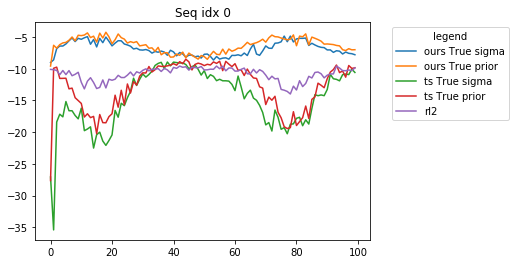

Here


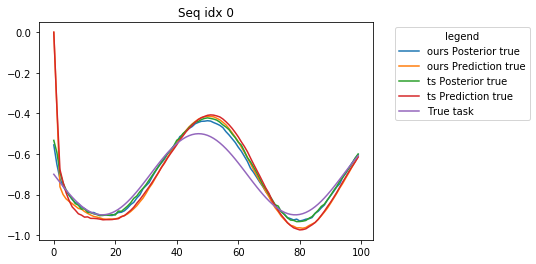

Seq 1 Algo ours = -10.078142045454545 +- 10.451062344040803
Seq 1 Algo True prior ours = -6.012534090909091 +- 2.708135758895875
Seq 1 Algo ts = -19.556488636363635 +- 14.088082798297611
Seq 1 Algo True prior ts = -15.169068181818183 +- 8.1819301777057
Seq 1 Algo rl2 = -12.454380681818183 +- 9.165787163040038


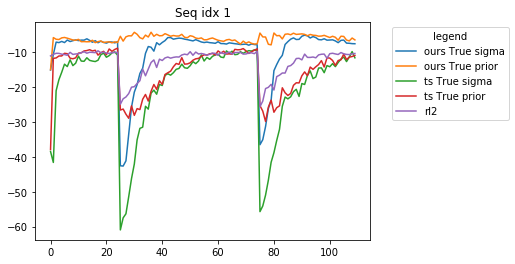

Here


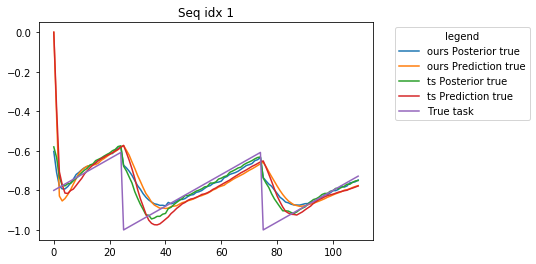

In [16]:
import pickle
from gym import spaces
import torch
import custom_env
import numpy as np
import torch
import os
from gym import spaces
from joblib import Parallel, delayed
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel, DotProduct

from learner.ours import OursAgent
from learner.posterior_ts_opt import PosteriorOptTSAgent
from learner.recurrent import RL2
from task.mini_golf_task_generator import MiniGolfTaskGenerator
from task.scaled_gauss_task_generator import ScaledGaussTaskGenerator
from utilities.folder_management import handle_folder_creation

objects = []
with (open("../result/data_results.pkl", "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break
            
o = objects[0]

folder = "result/metatest/minigolf/"
env_name = "gym_sin:minigolf-v0"
folder_list = ["result/golf_fixed_final/ours/",
               "result/golf_fixed_final/tsopt/",
               "result/golf_fixed_final/rl2low/"]
algo_list = ['ours', 'ts_opt', 'rl2']
label_list = ['ours', 'ts_opt', 'rl2']
has_track_list = [True, True, False]
store_history_list = [True, True, False]
prior_var_min = 0.001
prior_var_max = 0.2
noise_seq_var = 0.001
min_action = 1e-5
max_action = 10.
action_space = spaces.Box(low=min_action,
                          high=max_action,
                          shape=(1,))

num_seq = 2
seq_len_list = [100, 110]
sequence_name_list = ['sin', 'sawtooth']


def f_sin(x, freq=0.1, offset=-0.7, a=-0.2):
    t = a * np.sin(freq * x) + offset
    return t


def f_sawtooth(x, period=50):
    saw_tooth = 2 * (x / period - np.floor(0.5 + x / period))
    saw_tooth = (-0.6 - (-1)) / (1 - (-1)) * (saw_tooth - 1) - 0.6
    return saw_tooth


def get_sin_task_sequence_full_range(n_restarts, num_test_processes, std):
    kernel = C(1) * RBF(1) + WhiteKernel(0.01, noise_level_bounds="fixed") + DotProduct(1)

    gp_list = []
    for i in range(num_test_processes):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])

    init_prior_test = [torch.tensor([[0.], [0.2 ** (1 / 2)]], dtype=torch.float32)
                       for _ in range(num_test_processes)]

    prior_seq = []
    for idx in range(0, 100):
        friction = f_sin(idx)
        prior_seq.append(torch.tensor([[friction], [std ** 2]], dtype=torch.float32))

    return gp_list, prior_seq, init_prior_test


def get_sawtooth_wave(n_restarts, num_test_processes, std):
    kernel = C(1) * RBF(1) + WhiteKernel(0.01, noise_level_bounds="fixed") + DotProduct(1)

    gp_list = []
    for i in range(num_test_processes):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])

    init_prior_test = [torch.tensor([[0.], [0.2 ** (1 / 2)]], dtype=torch.float32)
                       for _ in range(num_test_processes)]

    prior_seq = []
    for idx in range(0, 110):
        friction = f_sawtooth(idx)
        prior_seq.append(torch.tensor([[friction], [std ** 2]], dtype=torch.float32))

    return gp_list, prior_seq, init_prior_test


def get_sequences(n_restarts, num_test_processes, std):
    # Retrieve task
    gp_list_sin, prior_seq_sin, init_prior_sin = get_sin_task_sequence_full_range(n_restarts, num_test_processes, std)
    gp_list_saw, prior_seq_saw, init_prior_saw = get_sawtooth_wave(n_restarts, num_test_processes, std)

    # Fill lists
    p = [prior_seq_sin, prior_seq_saw]
    gp = [gp_list_sin, gp_list_saw]
    ip = [init_prior_sin, init_prior_saw]
    return p, gp, ip


# Create python plots from meta-test results
prior_sequences, gp_list_sequences, init_prior = get_sequences(n_restarts=10,
                                                               num_test_processes=1,
                                                               std=noise_seq_var ** (1 / 2))

fd, folder_path_with_date = handle_folder_creation(result_path=folder)
view_results_multiple_dim(o, ['ours', 'ts', 'rl2'], [True, True, False], len(init_prior), prior_sequences,
                          init_priors=init_prior,
                          rescale_latent=None,
                          dump_data=False,
                          save_fig=False,
                          folder=folder_path_with_date,
                          view_tracking=True,
                          num_dim=1,
                          show_no_tracking=False)

# GAUSS

Seq 0 Algo ours = 9.400096896 +- 3.986526998587712
Seq 0 Algo True prior ours = 10.475278169208336 +- 3.098137928677993
Seq 0 Algo No tracking ours = 9.534835536666668 +- 3.2528157093188343
Seq 0 Algo ts = 5.590027677208333 +- 3.484385989299955
Seq 0 Algo True prior ts = 7.163952101583333 +- 2.983106775222172
Seq 0 Algo No tracking ts = 4.845136126666667 +- 3.756835039124013
Seq 0 Algo rl2 = -8.936769424708332 +- 16.14674811613796


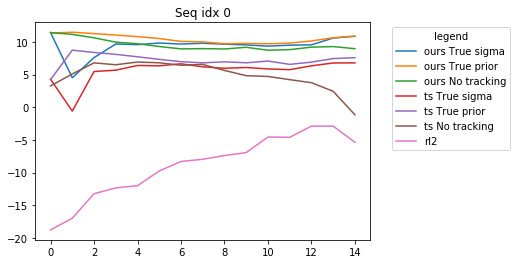

Here


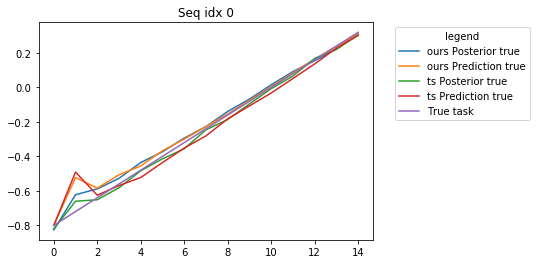

Seq 1 Algo ours = 9.38931219434375 +- 2.8169759500478015
Seq 1 Algo True prior ours = 9.767690797437501 +- 2.557465391327705
Seq 1 Algo No tracking ours = 8.61955031915625 +- 3.3473571386821592
Seq 1 Algo ts = 5.9464785053750004 +- 2.8079857196039333
Seq 1 Algo True prior ts = 6.8519109549375 +- 2.883000923506369
Seq 1 Algo No tracking ts = 5.60663383165625 +- 2.872516582315553
Seq 1 Algo rl2 = -4.61856616246875 +- 16.49640498424916


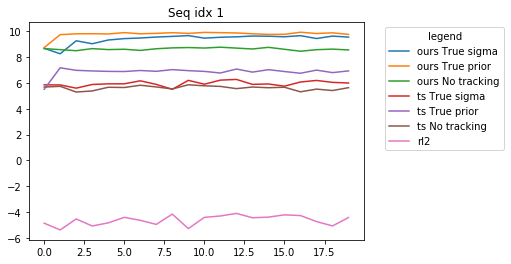

Here


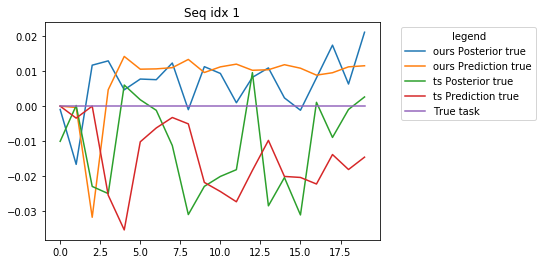

Seq 2 Algo ours = 6.260523433375 +- 9.504728220528783
Seq 2 Algo True prior ours = 10.365551223604168 +- 2.9486240531119425
Seq 2 Algo No tracking ours = 7.8263282824375 +- 5.46589519122741
Seq 2 Algo ts = 5.413227844895834 +- 4.297232328175471
Seq 2 Algo True prior ts = 7.438276763354167 +- 2.8698644254451615
Seq 2 Algo No tracking ts = 4.1755661715 +- 3.9261040523551234
Seq 2 Algo rl2 = -8.236004762479167 +- 15.51718473251495


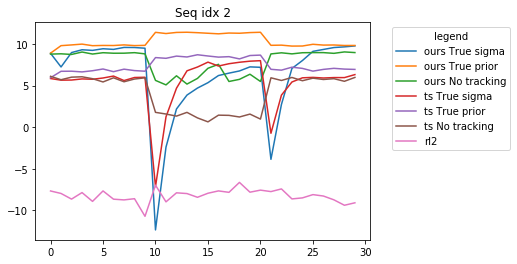

Here


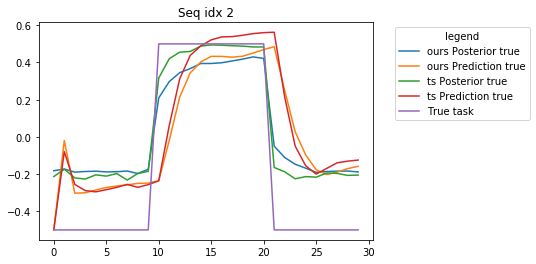

Seq 3 Algo ours = 4.0603963276562505 +- 10.667143750960694
Seq 3 Algo True prior ours = 11.16329915384375 +- 2.9556317509924583
Seq 3 Algo No tracking ours = -6.438802804093751 +- 17.158886471461194
Seq 3 Algo ts = 6.26678592134375 +- 6.813465225458617
Seq 3 Algo True prior ts = 9.869929233921875 +- 2.229361770334506
Seq 3 Algo No tracking ts = -10.00305618921875 +- 14.029978638951569
Seq 3 Algo rl2 = -16.708376332734375 +- 14.07901784654491


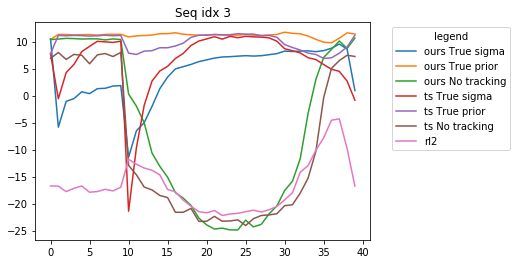

Here


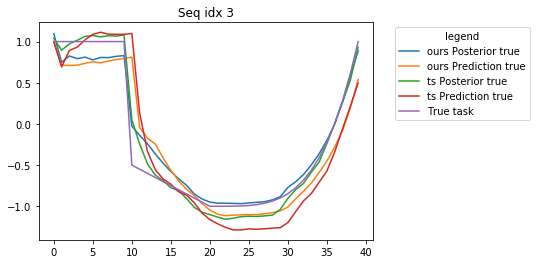

In [521]:
import pickle
objects = []
with (open("../result/metatest/scalegauss/data_results.pkl", "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break
            
o = objects[0]

import custom_env
import numpy as np
import torch
import os
from gym import spaces
from joblib import Parallel, delayed
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel, DotProduct

from learner.ours import OursAgent
from learner.posterior_ts_opt import PosteriorOptTSAgent
from learner.recurrent import RL2
from task.mini_golf_task_generator import MiniGolfTaskGenerator
from task.scaled_gauss_task_generator import ScaledGaussTaskGenerator
from utilities.folder_management import handle_folder_creation
from utilities.plots import view_results, create_csv_rewards, create_csv_tracking
from utilities.test_arguments import get_test_args
folder = "result/metatest/scalegauss/"
env_name = "custom_env:scalegauss-v0"
folder_list = ["result/scalegauss_final/ours/",
               "result/scalegauss_final/tsopt/",
               "result/scalegauss_final/rl2/"]
algo_list = ['ours', 'ts_opt', 'rl2']
label_list = ['ours', 'ts_opt', 'rl2']
has_track_list = [True, True, False]
store_history_list = [True, True, False]
prior_var_min = 0.001
prior_var_max = 0.5
noise_seq_var = 0.001
latent_dim = 1
min_action = -1.
max_action = 1.
action_space = spaces.Box(low=min_action,
                          high=max_action,
                          shape=(1,))

num_seq = 4
seq_len_list = [15, 20, 30, 40]
sequence_name_list = ['linear', 'const', "doublestep", 'mix']


def f_double_step(x, y_min=-0.5, y_max=0.5, first_peak=10, second_peak=20):
    if x < first_peak or x > second_peak:
        return y_min
    return y_max


def f_linear(x, m=0.08, q=-0.8):
    return x * m + q


def f_const(x, const=0):
    return const


def f_mixture_changes(x):
    if x < 10:
        return 1
    elif 20 > x >= 10:
        return 0 - (x / 20)
    elif x >= 20:
        return -1 + np.power((x - 20), 4) / (130321 / 2)


def get_const_task_sequence(n_restarts, num_test_processes, std):
    kernel = C(1) * RBF(1) + WhiteKernel(0.1, noise_level_bounds="fixed") + DotProduct(1)

    gp_list = []
    for i in range(num_test_processes):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])

    init_prior_test = [torch.tensor([[f_const(0)], [0.2 ** (1 / 2)]], dtype=torch.float32)
                       for _ in range(num_test_processes)]

    prior_seq = []
    for idx in range(0, 20):
        friction = f_const(idx)
        prior_seq.append(torch.tensor([[friction], [std ** 2]], dtype=torch.float32))

    return gp_list, prior_seq, init_prior_test


def get_linear_task_sequence(n_restarts, num_test_processes, std):
    kernel = C(1) * RBF(1) + WhiteKernel(0.1, noise_level_bounds="fixed") + DotProduct(1)

    gp_list = []
    for i in range(num_test_processes):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])

    init_prior_test = [torch.tensor([[f_linear(0)], [0.2 ** (1 / 2)]], dtype=torch.float32)
                       for _ in range(num_test_processes)]

    prior_seq = []
    for idx in range(0, 15):
        friction = f_linear(idx)
        prior_seq.append(torch.tensor([[friction], [std ** 2]], dtype=torch.float32))

    return gp_list, prior_seq, init_prior_test


def get_double_step_sequences(n_restarts, num_test_processes, std):
    kernel = C(1) * RBF(1) + WhiteKernel(0.1, noise_level_bounds="fixed") + DotProduct(1)

    gp_list = []
    for i in range(num_test_processes):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])

    init_prior_test = [torch.tensor([[f_double_step(0)], [0.2 ** (1 / 2)]], dtype=torch.float32)
                       for _ in range(num_test_processes)]

    prior_seq = []
    for idx in range(0, 30):
        friction = f_double_step(idx)
        prior_seq.append(torch.tensor([[friction], [std ** 2]], dtype=torch.float32))

    return gp_list, prior_seq, init_prior_test


def get_strange_sequences(n_restarts, num_test_processes, std):
    kernel = C(1) * RBF(1) + WhiteKernel(0.1, noise_level_bounds="fixed") + DotProduct(1)

    gp_list = []
    for i in range(num_test_processes):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])

    init_prior_test = [torch.tensor([[f_mixture_changes(0)], [0.2 ** (1 / 2)]], dtype=torch.float32)
                       for _ in range(num_test_processes)]

    prior_seq = []
    for idx in range(0, 40):
        friction = f_mixture_changes(idx)
        prior_seq.append(torch.tensor([[friction], [std ** 2]], dtype=torch.float32))

    return gp_list, prior_seq, init_prior_test


def get_sequences(n_restarts, num_test_processes, std):
    # Retrieve task
    gp_list_const, prior_seq_const, init_prior_const = get_const_task_sequence(n_restarts, num_test_processes, std)
    gp_list_lin, prior_seq_lin, init_prior_lin = get_linear_task_sequence(n_restarts, num_test_processes, std)
    gp_list_step, prior_seq_step, init_prior_step = get_double_step_sequences(n_restarts, num_test_processes, std)
    gp_list_mix, prior_seq_mix, init_prior_mix = get_strange_sequences(n_restarts, num_test_processes, std)

    # Fill lists
    p = [prior_seq_lin, prior_seq_const, prior_seq_step, prior_seq_mix]
    gp = [gp_list_lin, gp_list_const, gp_list_step, gp_list_mix]
    ip = [init_prior_lin, init_prior_const, init_prior_step, init_prior_mix]
    return p, gp, ip

prior_sequences, gp_list_sequences, init_prior = get_sequences(n_restarts=10,
                                                               num_test_processes=5,
                                                               std=noise_seq_var ** (1 / 2))

fd, folder_path_with_date = handle_folder_creation(result_path=folder)

view_results_multiple_dim(o, ['ours', 'ts', 'rl2'], [True, True, False], len(init_prior), prior_sequences,
                          init_priors=init_prior,
                          rescale_latent=None,
                          dump_data=False,
                          save_fig=False,
                          folder=folder_path_with_date,
                          view_tracking=True,
                          num_dim=1,
                          show_no_tracking=True)

# Cheetah

Seq 0 Algo ours = -31.45627666266666 +- 29.79398255973672
Seq 0 Algo True prior ours = -27.170156459999998 +- 18.477709864256035
Seq 0 Algo ts = -27.704079680666666 +- 22.898503717095608
Seq 0 Algo True prior ts = -24.341340170000002 +- 18.620738118896522
Seq 0 Algo rl2 = -56.338544298666676 +- 37.45921498771947


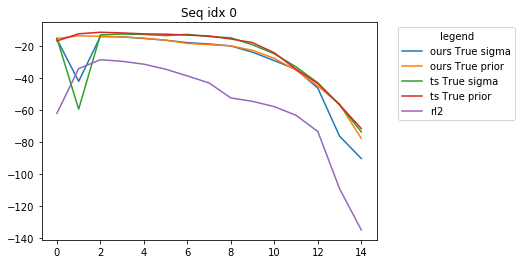

Here


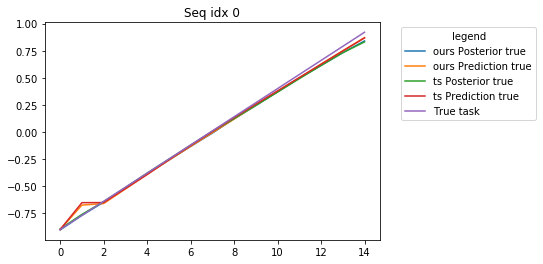

Seq 1 Algo ours = -61.2388239745 +- 17.880263666870114
Seq 1 Algo True prior ours = -58.1336010575 +- 9.053131228556794
Seq 1 Algo ts = -63.44976417150001 +- 23.24583466386556
Seq 1 Algo True prior ts = -58.0154403745 +- 5.583273811033982
Seq 1 Algo rl2 = -96.22988324500002 +- 22.525992248789606


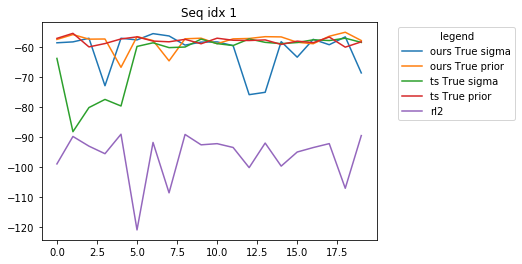

Here


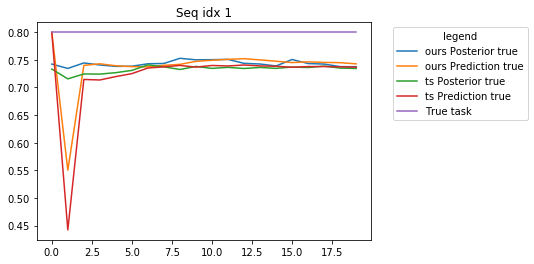

Seq 2 Algo ours = -57.31098608999999 +- 73.47915903081692
Seq 2 Algo True prior ours = -44.299430662 +- 31.006191062814274
Seq 2 Algo ts = -65.29788712766667 +- 96.46907520071623
Seq 2 Algo True prior ts = -41.174654184666664 +- 29.930596713218385
Seq 2 Algo rl2 = -81.77046058466665 +- 51.71024927923748


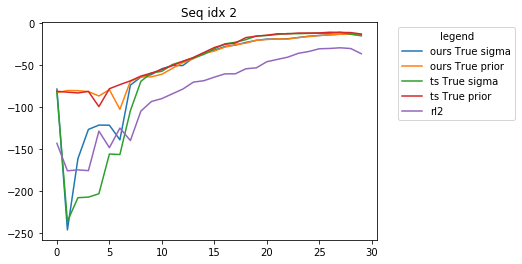

Here


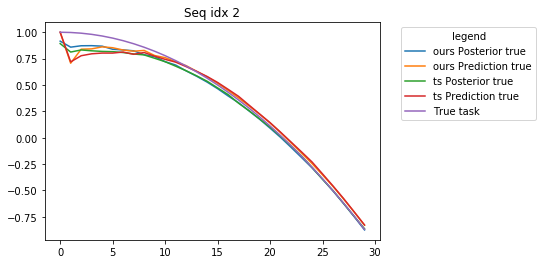

In [7]:


objects = []

with (open("../result/metatest/cheetahvelv2/Nov19_21-40-41/data_results.pkl", "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break
            
o = objects[0]


# Task family parameters
prior_var_min = 0.01
prior_var_max = 0.3
noise_seq_var = 0.00001
latent_dim = 1
high_act = np.ones(6, dtype=np.float32)
low_act = -np.ones(6, dtype=np.float32)
action_space = spaces.Box(low=low_act, high=high_act)
prior_std_max = [prior_var_max ** (1 / 2) for _ in range(latent_dim)]
prior_std_min = [prior_var_min ** (1 / 2) for _ in range(latent_dim)]

num_seq = 3
seq_len_list = [15, 20, 30]
sequence_name_list = ['const_acc', 'const', 'quad_dec']


def f_linear(x, m=0.13, q=-0.9):
    return x * m + q


def f_quadratic(x):
    a = -2 / 900
    b = 0
    c = 1
    return a * (x ** 2) + b * x + c


def get_linear_deceleration(num_test_processes, n_restarts, std, seq_len):
    kernel = C(1) * RBF(1) + WhiteKernel(0.01, noise_level_bounds="fixed") + DotProduct(1)

    gp_list = []
    for i in range(latent_dim):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])

    target_vel = f_quadratic(0)
    init_prior_test = [torch.tensor([[target_vel], [1 ** (1 / 2)]], dtype=torch.float32)
                       for _ in range(num_test_processes)]

    prior_seq = []
    for idx in range(0, seq_len):
        target_vel = f_quadratic(x=idx)
        prior_seq.append(torch.tensor([[target_vel], [std ** 2]], dtype=torch.float32))

    return gp_list, prior_seq, init_prior_test


def get_constant_speed(num_test_processes, n_restarts, std, seq_len):
    kernel = C(1) * RBF(1) + WhiteKernel(0.01, noise_level_bounds="fixed") + DotProduct(1)

    gp_list = []
    for i in range(latent_dim):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])

    target_vel = 0.8

    init_prior_test = [torch.tensor([[target_vel], [1 ** (1 / 2)]], dtype=torch.float32)
                       for _ in range(num_test_processes)]


    prior_seq = []
    for idx in range(0, seq_len):
        prior_seq.append(torch.tensor([[target_vel], [std ** 2]], dtype=torch.float32))

    return gp_list, prior_seq, init_prior_test


def get_constant_acceleration(num_test_processes, n_restarts, std, seq_len):
    kernel = C(1) * RBF(1) + WhiteKernel(0.01, noise_level_bounds="fixed") + DotProduct(1)

    gp_list = []
    for i in range(latent_dim):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])

    init_prior_test = [torch.tensor([[f_linear(0)], [1 ** (1 / 2)]], dtype=torch.float32)
                       for _ in range(num_test_processes)]

    prior_seq = []
    for idx in range(0, seq_len):
        vel = f_linear(idx)
        prior_seq.append(torch.tensor([[vel], [std ** 2]], dtype=torch.float32))

    return gp_list, prior_seq, init_prior_test


def get_sequences(n_restarts, num_test_processes, std):
    # Retrieve task
    gp_list_const_acc, prior_seq_const_acc, init_prior_const_acc= get_constant_acceleration(
        num_test_processes=num_test_processes,
        std=std,
        n_restarts=n_restarts,
        seq_len=15)

    gp_list_const, prior_seq_const, init_prior_const = get_constant_speed(
        num_test_processes=num_test_processes,
        std=std,
        n_restarts=n_restarts,
        seq_len=20
    )

    gp_list_quad, prior_seq_quad, init_prior_quad = get_linear_deceleration(
        num_test_processes=num_test_processes,
        std=std,
        n_restarts=n_restarts,
        seq_len=30
    )

    # Fill lists
    p = [prior_seq_const_acc, prior_seq_const, prior_seq_quad]
    gp = [gp_list_const_acc, gp_list_const, gp_list_quad]
    ip = [init_prior_const_acc, init_prior_const, init_prior_quad]

    return p, gp, ip

# Create python plots from meta-test results
prior_sequences, gp_list_sequences, init_prior = get_sequences(n_restarts=10,
                                                               num_test_processes=1,
                                                               std=noise_seq_var ** (1 / 2))

fd, folder_path_with_date = handle_folder_creation(result_path=folder)
#view_results_real(o, ['ours', 'ts', 'rl2'], [True, True,False], len(init_prior), prior_sequences,
#             init_priors=init_prior,
#             rescale_latent=[0, 5],
#             dump_data=False,
#             save_fig=False,
#             folder=folder_path_with_date,
#             view_tracking=False,
#                 plot_no_tracking=False)

view_results_multiple_dim(o, ['ours', 'ts', 'rl2'], [True, True, False], len(init_prior), prior_sequences,
                          init_priors=init_prior,
                          rescale_latent=None,
                          dump_data=False,
                          save_fig=False,
                          folder=folder_path_with_date,
                          view_tracking=True,
                          num_dim=1,
                          show_no_tracking=False)


# Ant goal

Seq 0 Algo ours = -255.501248242 +- 41.85795020211134
Seq 0 Algo True prior ours = -237.37328673799996 +- 35.979450515312855
Seq 0 Algo No tracking ours = -433.040183146 +- 145.11094452292002
Seq 0 Algo ts = -233.73330730499998 +- 41.48029684484742
Seq 0 Algo True prior ts = -225.90420914549998 +- 39.29519695531752
Seq 0 Algo No tracking ts = -401.409278644 +- 159.05682370199813
Seq 0 Algo rl2 = -540.8435222864999 +- 172.34675977235634


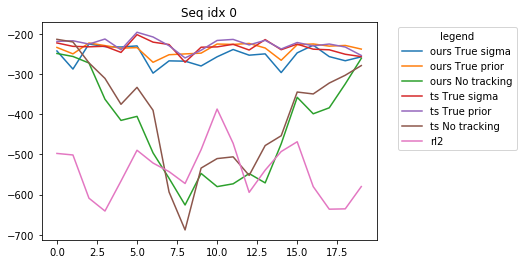

Here


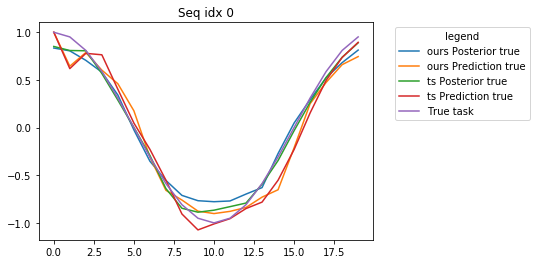

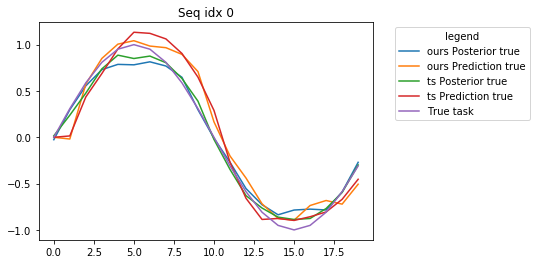

Seq 1 Algo ours = -238.69535784966672 +- 39.35019842179827
Seq 1 Algo True prior ours = -238.023965693 +- 41.975802942466416
Seq 1 Algo No tracking ours = -237.63950191433332 +- 40.60550580939769
Seq 1 Algo ts = -236.76153235200002 +- 42.85292731935718
Seq 1 Algo True prior ts = -234.10333800599997 +- 42.14530758035352
Seq 1 Algo No tracking ts = -234.26643795700002 +- 43.188391147406136
Seq 1 Algo rl2 = -618.936959038 +- 167.27703465355768


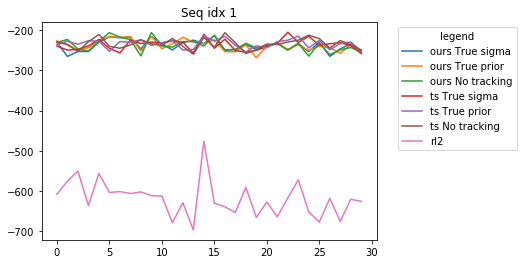

Here


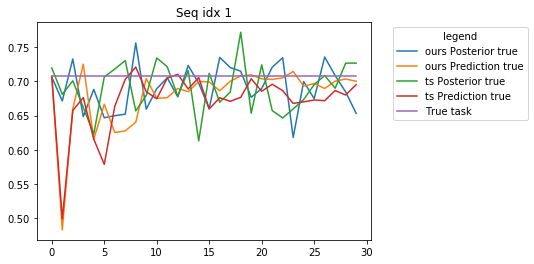

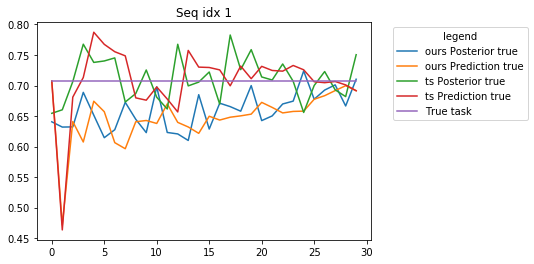

Seq 2 Algo ours = -255.77527102925 +- 56.85806208808962
Seq 2 Algo True prior ours = -243.87121801925002 +- 46.10086670978115
Seq 2 Algo No tracking ours = -340.56079643925 +- 139.64005745982578
Seq 2 Algo ts = -246.67405441224997 +- 60.432584175773094
Seq 2 Algo True prior ts = -236.72081935499997 +- 48.10075635563274
Seq 2 Algo No tracking ts = -321.166605244 +- 123.04184347458704
Seq 2 Algo rl2 = -632.58310741575 +- 181.70333424543531


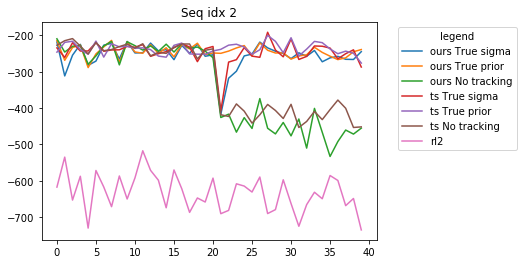

Here


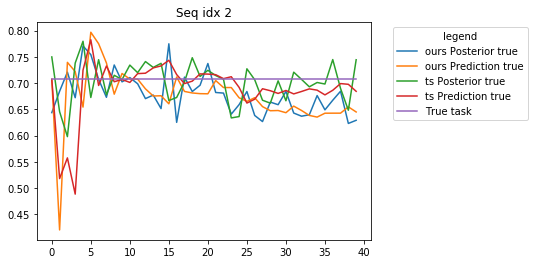

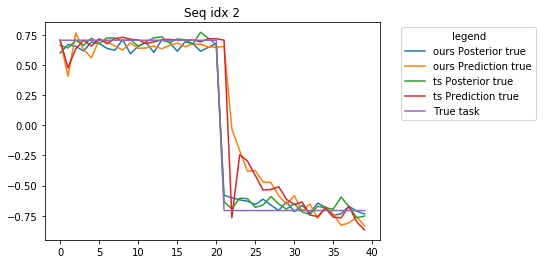

In [9]:
objects = []

with (open("../result/metatest/antgoal/Nov19_21-29-11/data_results.pkl", "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break
            
o = objects[0]

# Task family parameters
prior_var_min = 0.1
prior_var_max = 0.4
latent_dim = 2
state_dim = 113
action_dim = 8
noise_seq_var = 0.01
high_act = np.ones(8, dtype=np.float32)
low_act = -np.ones(8, dtype=np.float32)
action_space = spaces.Box(low=low_act, high=high_act)
prior_std_max = [prior_var_max ** (1 / 2) for _ in range(latent_dim)]
prior_std_min = [prior_var_min ** (1 / 2) for _ in range(latent_dim)]

num_seq = 3
seq_len_list = [20, 30, 40]
sequence_name_list = ['circuit', 'constant', 'step']


def f_radius(theta, latent_dim):
    if latent_dim == 0:
        return np.cos(theta)
    else:
        return np.sin(theta)


def linear_theta(x):
    return x * 2 * np.pi / 20


def get_circuit_sequences(n_restarts, num_test_processes, var_seq):
    std = var_seq ** (1 / 2)
    kernel = C(1) * RBF(1) + WhiteKernel(0.01, noise_level_bounds="fixed") + DotProduct(1)
    gp_list = []

    for _ in range(latent_dim):
        curr_dim_list = []
        for _ in range(num_test_processes):
            curr_dim_list.append(GaussianProcessRegressor(kernel=kernel,
                                                          normalize_y=False,
                                                          n_restarts_optimizer=n_restarts))
        gp_list.append(curr_dim_list)

    # Creating prior distribution
    p_mean = []
    p_var = []
    for dim in range(latent_dim):
        p_mean.append(f_radius(theta=0, latent_dim=dim))
        p_var.append(std ** 2)
    init_prior_test = [torch.tensor([p_mean, p_var], dtype=torch.float32)
                       for _ in range(num_test_processes)]

    # Create prior sequence
    prior_seq = []
    for idx in range(20):
        p_mean = []
        p_var = []
        theta = linear_theta(idx)
        for dim in range(latent_dim):
            p_mean.append(f_radius(theta=theta, latent_dim=dim))
            p_var.append(std ** 2)

        prior_seq.append(torch.tensor([p_mean, p_var], dtype=torch.float32))

    return gp_list, prior_seq, init_prior_test


def get_constant_sequence(n_restarts, num_test_processes, var_seq):
    std = var_seq ** (1 / 2)
    kernel = C(1) * RBF(1) + WhiteKernel(0.01, noise_level_bounds="fixed") + DotProduct(1)
    gp_list = []

    for _ in range(latent_dim):
        curr_dim_list = []
        for _ in range(num_test_processes):
            curr_dim_list.append(GaussianProcessRegressor(kernel=kernel,
                                                          normalize_y=False,
                                                          n_restarts_optimizer=n_restarts))
        gp_list.append(curr_dim_list)

    # Creating prior distribution
    theta_const = np.pi / 4
    p_mean = []
    p_var = []
    for dim in range(latent_dim):
        p_mean.append(f_radius(theta=theta_const, latent_dim=dim))
        p_var.append(std ** 2)
    init_prior_test = [torch.tensor([p_mean, p_var], dtype=torch.float32)
                       for _ in range(num_test_processes)]

    # Create prior sequence
    prior_seq = []
    for idx in range(30):
        p_mean = []
        p_var = []
        for dim in range(latent_dim):
            p_mean.append(f_radius(theta=theta_const, latent_dim=dim))
            p_var.append(std ** 2)

        prior_seq.append(torch.tensor([p_mean, p_var], dtype=torch.float32))

    return gp_list, prior_seq, init_prior_test


def get_step_sequence(n_restarts, num_test_processes, var_seq):
    std = var_seq ** (1 / 2)
    kernel = C(1) * RBF(1) + WhiteKernel(0.01, noise_level_bounds="fixed") + DotProduct(1)
    gp_list = []

    for _ in range(latent_dim):
        curr_dim_list = []
        for _ in range(num_test_processes):
            curr_dim_list.append(GaussianProcessRegressor(kernel=kernel,
                                                          normalize_y=False,
                                                          n_restarts_optimizer=n_restarts))
        gp_list.append(curr_dim_list)

    # Creating prior distribution
    theta = np.pi / 4
    p_mean = []
    p_var = []
    for dim in range(latent_dim):
        p_mean.append(f_radius(theta=theta, latent_dim=dim))
        p_var.append(std ** 2)
    init_prior_test = [torch.tensor([p_mean, p_var], dtype=torch.float32)
                       for _ in range(num_test_processes)]

    # Create prior sequence
    prior_seq = []
    for idx in range(40):
        p_mean = []
        p_var = []
        theta = np.pi / 4 if idx <= 20 else -np.pi / 4
        for dim in range(latent_dim):
            p_mean.append(f_radius(theta=theta, latent_dim=dim))
            p_var.append(std ** 2)

        prior_seq.append(torch.tensor([p_mean, p_var], dtype=torch.float32))

    return gp_list, prior_seq, init_prior_test


def get_sequences(n_restarts, num_test_processes, std):
    # Retrieve task
    gp_list_circuit, prior_seq_circuit, init_prior_circuit = get_circuit_sequences(
        num_test_processes=num_test_processes,
        n_restarts=n_restarts,
        var_seq=std ** 2
    )

    gp_list_constant, prior_seq_constant, init_prior_constant = get_constant_sequence(
        num_test_processes=num_test_processes,
        n_restarts=n_restarts,
        var_seq=std ** 2
    )

    gp_list_step, prior_seq_step, init_prior_step = get_step_sequence(
        num_test_processes=num_test_processes,
        n_restarts=n_restarts,
        var_seq=std ** 2
    )

    # Fill lists
    p = [prior_seq_circuit, prior_seq_constant, prior_seq_step]
    gp = [gp_list_circuit, gp_list_constant, gp_list_step]
    ip = [init_prior_circuit, init_prior_constant, init_prior_step]

    return p, gp, ip



# Create python plots from meta-test results
prior_sequences, gp_list_sequences, init_prior = get_sequences(n_restarts=10,
                                                               num_test_processes=1,
                                                               std=noise_seq_var ** (1 / 2))

fd, folder_path_with_date = handle_folder_creation(result_path=folder)
#view_results_real(o, ['ours', 'ts', 'rl2'], [True, True,False], len(init_prior), prior_sequences,
#             init_priors=init_prior,
#             rescale_latent=[0, 5],
#             dump_data=False,
#             save_fig=False,
#             folder=folder_path_with_date,
#             view_tracking=False,
#                 plot_no_tracking=False)

view_results_multiple_dim(o, ['ours', 'ts', 'rl2'], [True, True, False], len(init_prior), prior_sequences,
                          init_priors=init_prior,
                          rescale_latent=None,
                          dump_data=False,
                          save_fig=False,
                          folder=folder_path_with_date,
                          view_tracking=True,
                          num_dim=2,
                          show_no_tracking=True)


In [19]:
int('25')

25